# Training regressors to predict epigenomic-metabolic interactions
**Author**: Scott Campit

# Summary
This notebook trains several regressors of varying complexity and assumptions to learn the relationships between GCPs and metabolomics. This is a complementary approach to analyzing the data as opposed to an optimization and factorization standpoint.

## Mount Google Drive to Colab
This bit of code mounts Drive to the Colab notebook, and writes in an accessory function that is needed to read in Google Sheets as Pandas dataframes.

In [1]:
# Import necessary data science libraries
import pandas as pd
import numpy as np

# Load relevant libraries for Google Colab
from google.colab import auth
auth.authenticate_user()

# Allows us to read in Google Sheets via url
import gspread
from oauth2client.client import GoogleCredentials
gc = gspread.authorize(GoogleCredentials.get_application_default())

# Mount Google Drive, which will allow you to read in files within your Google 
# Drive if you wish to repurpose this for other datasets
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Accessory functions
I use this code to read in various Google sheets as Pandas dataframes. So here's a function that simplifies this operation by a lot. 

In [2]:
def read_gsheet(url='', sheetname=''):
  """
  read_gsheet reads in a Google sheet via the shared url and sheetname, and 
  outputs a pandas dataframe.

  params:
    url:       A string containing the url to the Google sheet.
    sheetname: A string containing the sheet name to be read in.
|
  return:
    df:        A Pandas dataframe of the data set.

  """
  # Read in Google sheet data
  wb = gc.open_by_url(url)
  wks = wb.worksheet(sheetname)
  data = wks.get_all_values()

  # Construct dataframe with the first row as column names
  df = pd.DataFrame(data)
  header = df.iloc[0]
  df = df[1:]
  df.columns = header
  
  return df

def save_gsheet(df, url='', sheetname=''):
  """
  save_gsheet saves a dataframe to a Google sheet using a url and a specified
  sheetname.

  :params df:        A pandas dataframe.
  :params url:       A string of the url to save the pandas dataframe data in.
  :params sheetname: A string of the sheet.
  """
  
  gc = gspread.authorize(GoogleCredentials.get_application_default())
  wb = gc.open_by_url(url)
  wb = wb.add_worksheet(title=sheetname, 
                        rows=str(df.shape[0]), 
                        cols=str(df.shape[1]))
  set_with_dataframe(wb, df)

# 1. Univariate modeling without PCA 
This code block will train several univariate models for each target variable $Y_{i}$, given the input dataset $X$. 

## 1a. Load Single Metabolomics and GCP datasets
This code block loads the GCP and metabolomics datasets for single histone markers and metabolites.

In [3]:
gcp_url = 'https://docs.google.com/spreadsheets/d/1eRwYUZve16ALg-DvwAooWPvMJfRn8j6ggUp-HVDb84A/edit?usp=sharing'
met_url = 'https://docs.google.com/spreadsheets/d/1V1JEugHtnQrfqOxFD-Nsqa3KM2PaegNsp22J4dp8vy4/edit?usp=sharing'

GCP = read_gsheet(url=gcp_url, sheetname='ACME')
MET = read_gsheet(met_url, sheetname='All + FA')

print(GCP.shape)
print(MET.shape)

(866, 20)
(922, 229)


Let's also get a preview of the datasets

In [5]:
print(GCP.head(10))
print(MET.head(10))

0  Cell Line     H3K4me1     H3K4me2  ...    H3K18ac1    H3K23ac1    H3K27ac1
1      DMS53  -0.1531442  -0.3486065  ...   0.2496178  -0.0884068   0.3961776
2     SW1116   0.2195920   0.1109460  ...  -0.0157371  -0.0006368  -1.1987087
3   NCIH1694   0.2984405   0.0737769  ...   0.5121219   0.3084320   0.0556831
4      P3HR1  -0.6176561  -0.5667022  ...  -0.2495383   0.5328243   1.0983032
5      HUT78  -0.0634827  -0.2679798  ...  -0.3318869   0.4372361  -0.1852371
6        HOS  -0.8711033  -0.3824573  ...  -0.5963677  -0.3554513  -1.3242442
7      HUNS1   0.1930755  -0.0012647  ...   0.2394005   0.3011758   0.9116514
8     AML193  -0.1011066   0.1978929  ...  -0.3523935  -0.0826956   0.7839688
9     RVH421   0.5860153   0.4079715  ...  -0.0665331  -0.0533031   0.1189508
10  NCIH1184  -0.2868374  -0.5306052  ...  -0.3503078   0.5571621   0.3415113

[10 rows x 20 columns]
0        CCL                              Tissue  ...  C58:7 TAG  C58:6 TAG
1      DMS53                              

We don't need some of the meta data in the `MET` dataframe

In [8]:
MET = MET.drop(["Tissue", "Medium", "Culture"], axis=1)

## 1b. Get intersecting cancer cell lines between the two datasets
To preprocess the data, we'll do a couple of things, including:
  * Match by cell lines
  * Sort by index
  * Remove unncessary columns
  * Z-score the metabolomics data

In [13]:
idx = list(set(GCP['Cell Line']) & set(MET['CCL']))
GCP = GCP[GCP['Cell Line'].isin(idx)]
MET = MET[MET['CCL'].isin(idx)]
GCP = GCP.drop_duplicates(subset='Cell Line', keep='first')
MET = MET.drop_duplicates(subset='CCL', keep='first')

GCP = GCP.sort_values(by=['Cell Line'])
MET = MET.sort_values(by=['CCL'])
print(GCP.shape)
print(MET.shape)

(856, 20)
(856, 226)


To sanity check, let's continue looking at the dataframes

In [21]:
print(GCP.head(10))
print(MET.head(10))

0       H3K4me1     H3K4me2     H3K9me1  ...    H3K18ac1    H3K23ac1    H3K27ac1
641  -0.2512602  -0.2274132   0.3150412  ...  -0.4148004  -0.0943335   0.0629570
604   0.2697713   0.6851092   0.3006411  ...   0.7507115   0.4953184   0.5998609
400   0.3390270   0.2093149   0.4704324  ...   0.3657141   0.7940381  -1.2267228
533   0.0688435  -0.1138058   0.3012251  ...   0.5073519  -0.1033642   0.7761469
534   0.1398449   0.4004617   0.3523635  ...   0.7418864   0.0534944   1.2434481
720  -0.4288802  -0.6536036  -0.0253918  ...   0.2987074  -0.7601617  -1.5644878
813  -0.0718378   0.2757602  -0.2940921  ...  -0.0845931  -0.3190413   0.0119563
630   0.3910465   0.8302224  -0.2861149  ...   0.6763371   0.1180649   1.5090501
510   0.6711108   0.6901795   0.1587771  ...  -0.0072835   0.1369984   0.2160033
587   0.1008483   0.4760055   0.0099577  ...  -0.2841597  -0.4719930  -1.9797328

[10 rows x 19 columns]
0   2-aminoadipate 3-phosphoglycerate  ...  C58:7 TAG  C58:6 TAG
670      5.5475389  

Finally, we'll save the cell line names in a list, and remove them from their respective data frames.

In [20]:
cell_lines = list(GCP.pop('Cell Line'))
MET = MET.drop('CCL', axis=1)

## 1c. SANITY CHECK: Plot the data distributions for the metabolites and histone ratios
Let's check out the distributions between the two datasets. Note that for some reason the data is not being read as a numeric data type. Thus, I also need to coerce the data into a numeric data type.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


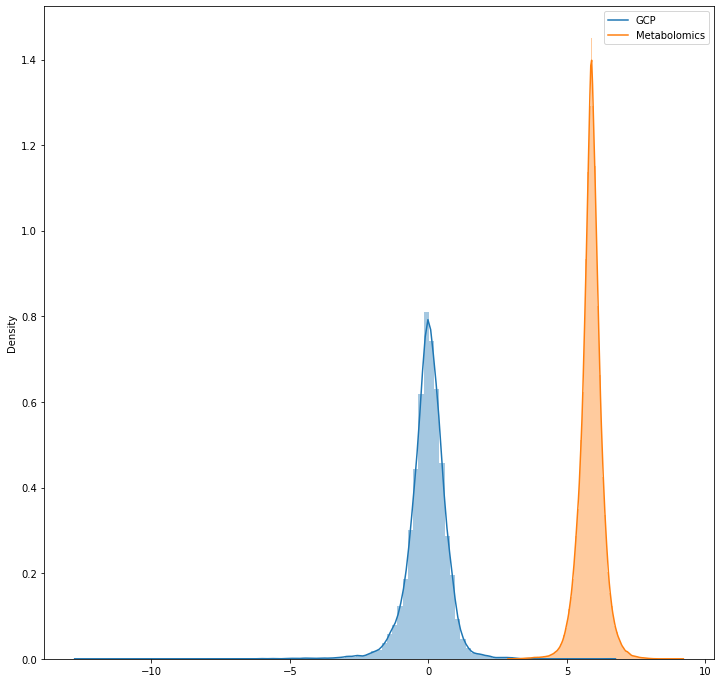

In [28]:
GCP = GCP.apply(pd.to_numeric, errors = 'coerce')
MET = MET.apply(pd.to_numeric, errors = 'coerce')

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 12))
sns.distplot(GCP, bins=100)
sns.distplot(MET, bins=100)
plt.legend(['GCP', 'Metabolomics'])

The only thing we'll probably need to do is mean center the metabolomics data.

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


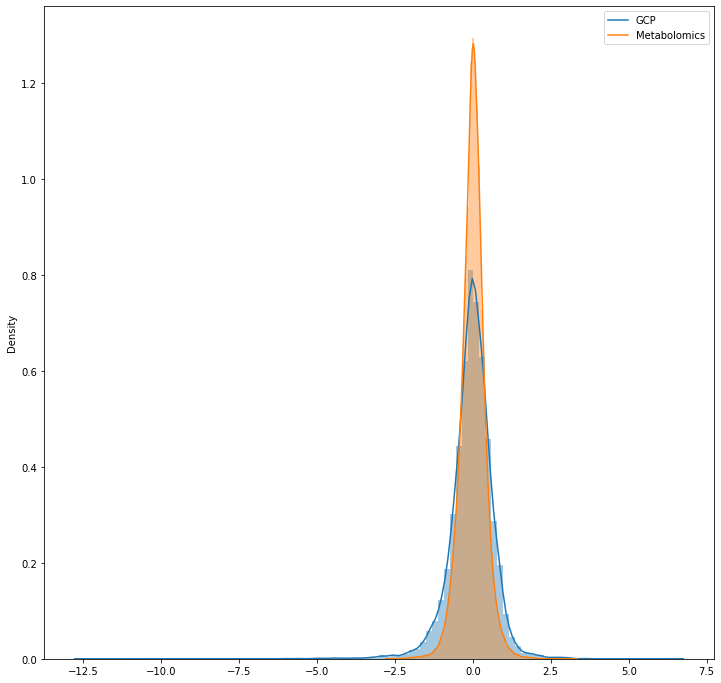

In [29]:
MET = MET - MET.mean()

import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(12, 12))
sns.distplot(GCP, bins=100)
sns.distplot(MET, bins=100)
plt.legend(['GCP', 'Metabolomics'])

## 1d. Train on GCP to predict metabolism
First, let's split the data into training and test sets.

In [30]:
from sklearn.model_selection import train_test_split

Convert to Numpy array.

In [58]:
GCP = GCP.to_numpy()
MET = MET.to_numpy()

AttributeError: ignored

Let's ensure all NaNs are 0.

In [59]:
# Ensure all values are finite
GCP = np.nan_to_num(GCP, nan=0)
MET = np.nan_to_num(MET, nan=0)

Split the data into validation (30%) and training (70%) data.

In [60]:
# Split the CCLE data into a validation set
Xtrain, Xval, Ytrain, Yval = train_test_split(
                                              GCP, MET, 
                                              test_size=0.3, random_state=0
)

Print $X_{train}$ and $Y_{train}$.

In [61]:
import sys
np.set_printoptions(threshold=sys.maxsize)
print(Xtrain)
print(Ytrain)

Streaming output truncated to the last 5000 lines.
  -4.23049816e-01 -6.56181963e-01 -5.44688281e-01 -5.94919169e-01
  -6.03036110e-01 -6.57101937e-01 -7.07073307e-01 -4.51405283e-01
  -4.42532688e-01 -1.54212779e-01 -8.29785043e-02 -9.12220408e-01
  -4.78860549e-01  1.95372137e-01 -1.22111676e+00  1.39255446e+00
   2.23109852e-02 -5.25480487e-01  9.39142874e-02 -5.60678035e-01
  -6.43088207e-01 -5.95280228e-01 -4.37656776e-01 -9.89611334e-01
  -2.97885995e-01 -1.91367189e-01 -7.88446965e-01 -7.39922745e-01
  -6.48133269e-01 -1.67879217e-03 -2.57967394e-01  1.53748742e-01
   4.70054284e-01  1.55577914e-01 -4.99193872e-01 -5.49074699e-01
   3.38748777e-01 -4.31405103e-01  2.03021748e-02  2.24799281e-01
   3.13348757e-01 -2.52087980e-01  2.54287940e-01 -1.89541986e-01
   1.69673281e-01 -9.71625607e-01 -4.71113820e-01  1.39821634e-01
  -2.85246880e-01 -1.54487304e-01 -8.69037924e-02 -8.38239523e-02
  -4.12231986e-01 -3.46508840e-01 -6.94082343e-02  3.54431592e-01
   4.04682980e-01  2.4946

Print shape of $X_{train}$ and $Y_{train}$.

In [38]:
print(Xtrain.shape)
print(Ytrain.shape)
print(Xval.shape)
print(Yval.shape)

(599, 19)
(599, 225)
(257, 19)
(257, 225)


Ensure that all values are finite.

In [39]:
print(np.sum(Xtrain == np.inf))
print(np.sum(Xtrain == -np.inf))
print(np.sum(Xtrain == np.NaN))
print(np.sum(Ytrain == np.inf))
print(np.sum(Ytrain == -np.inf))
print(np.sum(Ytrain == np.NaN))

0
0
0
0
0
0


### 1d.1. 3-fold cross validation for univariate regression
Now let's train a bunch of non-linear regressors and evaluate their performance.

We'll train the following regressors:
  * Ordinary least squares
  * Robust regression
  * Ridge
  * LASSO
  * Elastic Net
  * Support vector regressors
  * Random Forests
  * Extra Trees
  * Gradient boosting
  * XGBoost


In [52]:
# ML models
!pip install scikit-optimize
from sklearn import linear_model as lm
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor
!pip install xgboost
import xgboost as xgb

# Accessory functions
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

!pip3 install progressbar
from time import sleep
import progressbar

# Suppress annoying warnings
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
from joblib import Parallel, delayed, parallel_backend
from skopt import dump, load
from skopt.utils import use_named_args
from sklearn.multioutput import MultiOutputRegressor

import multiprocessing

### 1d.2. Load some hyperparameters to sample
Let's define the search parameters we'll use for hyperparameter optimization

In [43]:
# Robust 
robust_params = {
    'epsilon': Real(1, 10, "log-uniform"),
    'alpha': Real(10**-5, 10**0, "log-uniform")
}

# Ridge
ridge_params = {
    'alpha': Real(10**-5, 10**0, "log-uniform")
}

# LASSO
lasso_params = {
    'alpha': Real(10**-5, 10**0, "log-uniform")
}

# Elastic Net
en_params = {
    'alpha': Real(10**-5, 10**0, "log-uniform"),
    'l1_ratio': Real(10**-5, 10**0, "log-uniform")
}

# SVM
svm_params = {
    'kernel': {'linear', 'poly', 'rbf', 'sigmoid', 'precomputed'},
    'degree': Integer(1, 10),
    'gamma': Real(10**-5, 10**0, "log-uniform"),
    'C': Real(10**-5, 10**0, "log-uniform")
}

# Gradient boosting
gb_params = {
    'max_depth': Integer(1, 5),
    'max_features': Categorical(['auto', 'sqrt', 'log2']),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100),
    'learning_rate': Real(10**-5, 10**0, "log-uniform")
}

# Random Forests
rf_params = {
    'max_depth': Integer(1, 5),
    'max_features': Integer(1, Xtrain.shape[1]-1),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100)
}

# Extra Trees
et_params = {
    'max_depth': Integer(1, 5),
    'max_features': Integer(1, Xtrain.shape[1]-1),
    'min_samples_split': Integer(2, 100),
    'min_samples_leaf': Integer(1, 100),
}

# XGBoost
xgb_params ={
    'gamma': Integer(1, 10),
    'learning_rate': Real(10**-5, 0.99, prior="log-uniform"),
    'max_depth': Integer(3, 10),
    'reg_alpha': Real(10**-5, 1, prior="log-uniform"),
    'reg_lambda':Real(10**-5, 1, prior="log-uniform"),
    'max_delta_step': Integer(0, 10),
}

### 1d.3. Store everything in lists so we can iterate the code in a for loop
We'll run all steps as a single for loop. So we need to save the initial model structures, the hyperparameters, and the names of the pickled files in lists.

In [66]:
models = [
          lm.HuberRegressor(),
          lm.Ridge(),
          lm.Lasso(),
          lm.ElasticNet(),
          SVR(),
          RandomForestRegressor(),
          GradientBoostingRegressor(),
          ExtraTreesRegressor(),
          xgb.XGBRegressor()
]
params = [
          robust_params,
          ridge_params,
          lasso_params,
          en_params,
          svm_params,
          rf_params,
          gb_params,
          et_params,
          xgb_params
]

# Names stored on desktop
#names = [
#         '/home/scampit/Data/Models/GCP2Met/robust.pkl',
#         '/home/scampit/Data/Models/GCP2Met/ridge.pkl',
#         '/home/scampit/Data/Models/GCP2Met/lasso.pkl',
#         '/home/scampit/Data/Models/GCP2Met/en.pkl',
#         '/home/scampit/Data/Models/GCP2Met/svr.pkl',
#         '/home/scampit/Data/Models/GCP2Met/rf.pkl',
#         '/home/scampit/Data/Models/GCP2Met/gb.pkl',
#         '/home/scampit/Data/Models/GCP2Met/et.pkl',
#         '/home/scampit/Data/Models/GCP2Met/xgb.pkl'
#]

# Path for Google Drive
names = [
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/robust.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/ridge.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/lasso.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/en.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/svr.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/rf.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/gb.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/et.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/xgb.pkl'
]

### 1d.4. Specify k-folds operator
We'll specify the number of k-folds.

In [48]:
# Set the kfold operator to split 3 times with shuffle
kfold = KFold(n_splits=3, 
              shuffle=True, 
              random_state=0)

### 1d.5. Create a function that trains the models
We'll create a function that trains the model and performs the following steps:
  1. Define the BayesOpt object.
  2. Compute a model for each feature.
  3. Save all models based on a designated path.

In [64]:
def train_models(models, params, Xtrain, Ytrain, kfold, filename):
  """
  train_models performs kfold bayesian hyperparameter tuning for different 
  models, and saves the output for model persistence.

  :param models: A single sklearn model object or list of sklearn model objects.
  :param params: A dictionary or list of dictionaries containing hyperparameters 
                to tune.
  :param Xtrain: A numpy array or pandas dataframe containing the training data.
  :param Ytrain: A numpy array or pandas dataframe containing the output data.
  :param kfold:  An integer or sklearn object determining the kfold operation 
                performed.
  :param filename: A string or list of paths to save the models (pickle).

  """
  no_of_cpus = multiprocessing.cpu_count()

  with parallel_backend('threading', n_jobs=no_of_cpus):
    for i in range(len(models)):
      opt = BayesSearchCV(
                          estimator=models[i],
                          search_spaces=params[i],
                          n_iter=30,
                          cv=kfold,
                          n_jobs=-1,
                          random_state=0
      )

      mdls =[]
      bar.start()
      for j in range(Ytrain.shape[1]):
        _ = opt.fit(Xtrain, Ytrain[:, j])
        mdls.append(opt)
        dump(res=mdls, filename=filename[i])
        bar.update(j)
        sleep(0.1)
      print("Finished hyperparameter optimization and cross validation for model number: " 
                    + str(i))

Now let's train the models.

In [ ]:
train_models(models, params, Xtrain, Ytrain, kfold, names)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_huber.py:296: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_ite

## 1e. Train on metabolomics to predict GCP
Now we'll do the reverse problem, using the same hyperparameters and functions set up above. The only other thing we'll change besides the $X$ and $Y$ variables are the file names to save these sets of models.

In [ ]:
# Split the CCLE data into a validation set
Xtrain, Xval, Ytrain, Yval = train_test_split(
                                              MET, GCP, 
                                              test_size=0.3, random_state=0
)

# Desktop version
#names = [
#         '/home/scampit/Data/Models/Met2GCP/robust.pkl',
#         '/home/scampit/Data/Models/Met2GCP/ridge.pkl',
#         '/home/scampit/Data/Models/Met2GCP/lasso.pkl',
#         '/home/scampit/Data/Models/Met2GCP/en.pkl',
#         '/home/scampit/Data/Models/Met2GCP/svr.pkl',
#         '/home/scampit/Data/Models/Met2GCP/rf.pkl',
#         '/home/scampit/Data/Models/Met2GCP/gb.pkl',
#         '/home/scampit/Data/Models/Met2GCP/et.pkl',
#         '/home/scampit/Data/Models/Met2GCP/xgb.pkl'
#]

# Google Drive version
names = [
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/robust.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/ridge.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/lasso.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/en.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/svr.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/rf.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/gb.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/et.pkl',
         '/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/xgb.pkl'
]

train_models(models, params, Xtrain, Ytrain, kfold, names)

# 2. Evaluating the Univariate ML models without PCA
## 2.1 Evaluate the GCP to MET ML models
Now that I have some models trained up, it's time to create some data structures that will have the metrics I want. First, let's grab the validation set again from the `train_test_split()` function. Because the seed is set, it should get me the same entries.

In [ ]:
# Split the CCLE data into a validation set
Xtrain, Xval, Ytrain, Yval = train_test_split(
    GCP, MET, test_size=0.3, random_state=0
)

## 2.2 Load relevant evaluation libraries
Next, we'll load some libraries we'll be using to evaluate the predicted value against the true value.

In [ ]:
from scipy.stats import pearsonr
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

## 2.3 Load GCP -> Met ML models
Let's now load the models we have trained to predict metabolite values from chromatin profiles.

In [ ]:
# Local Machine
#mdls = [load('/home/scampit/Data/Models/GCP2Met/robust.pkl'),
#         load('/home/scampit/Data/Models/GCP2Met/ridge.pkl'),
#         load('/home/scampit/Data/Models/GCP2Met/lasso.pkl'),
#         load('/home/scampit/Data/Models/GCP2Met/en.pkl'),
#         load('/home/scampit/Data/Models/GCP2Met/svr.pkl'),
#         load('/home/scampit/Data/Models/GCP2Met/rf.pkl'),
#         load('/home/scampit/Data/Models/GCP2Met/gb.pkl'),
#         load('/home/scampit/Data/Models/GCP2Met/et.pkl'),
#         load('/home/scampit/Data/Models/GCP2Met/xgb.pkl')
#]

# Google Drive
mdls = [load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/robust.pkl'),
         load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/ridge.pkl'),
         load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/lasso.pkl'),
         load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/en.pkl'),
         load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/svr.pkl'),
         load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/rf.pkl'),
         load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/gb.pkl'),
         load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/et.pkl'),
         load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/GCP2MET/xgb.pkl')
]

## 2.4 Create a function that will evaluate the models
The `evaluate_models()` function will compute evaluation metrics and spit out the final metrics of interest.

In [ ]:
def evaluate_models(models, Xval, Yval):
  """
  evaluate_models returns metrics from the model predictions, include the pearson
  correlation coefficient, coefficient of determination, MSE, and MAE.

  :param models:         A scikit-learn model object or list of model objects.
  :param Xval:           A numpy array or pandas dataframe containing 
                         validation set input data.
  :param Yval:           A numpy array or pandas dataframe containing 
                         validation set output data.
  :return final_metrics: A pandas dataframe or list of dfs containing the final 
                         evaluation metrics
  """

  final_metrics = []
  for j = 1 in range(len(models)):
    # Iterate through model objects
    m = models[j]

    r_values = list()
    p_values = list()
    mse_values = list()
    mae_values = list()

    # Iterate through features
    for i in range(len(m)):
      mdl = m[i]
      ypred = mdl.predict(Xval)
      r, pvalue = pearsonr(ypred, Yval[:, i])
      mse = mean_squared_error(ypred, Yval[:, i])
      mae = mean_absolute_error(ypred, Yval[:, i])

      r_values.append(r)
      p_values.append(pvalue)
      mae.append(mae)
      mse.append(mse)

    # Save the metrics in a dataframe
    pre_df = {
              "Pearson": r_values, 
              "Pvalue":  p_values,
              "MSE":     mse,
              "MAE":     mae
              }
    df = pd.DataFrame(pre_df)
    final_metrics.append(df)

    return final_metrics

## 2.5 Evaluate the models
Then we'll perform the following operations:
  1. Concatenate the results into a single dataframe
  2. Append the metabolite names to the list
  3. Sort the values in ascending alphabetical order by metabolite name
  4. Save the final results to the Google Sheet.

In [ ]:
final_metrics = evaluate_models(mdls, Xval, Yval)

# Flatten the array so that 
final_metrics = pd.concat(final_metrics, axis=1)
final_metrics["Metabolites"] = metabolites
final_metrics = final_metrics.sort_values(by=["Metabolites"], 
                                          axis=1, 
                                          ascending=True)

# Save to Google Sheet 
url = 'https://docs.google.com/spreadsheets/d/1_tFjeBplSfozCw0VIU84j8d0NTm4CyOAFr9tXQfBLoE/edit?usp=sharing'
sheetname = 'GCP2Met'
save_gsheet(final_metrics, url, sheetname)

# Save to local
path = '/home/scampit/Data/Models/GCP2Met/gcp2met_metrics.csv'
final_metrics.to_csv(path)

# Save to server
path = '/nfs/turbo/umms-csriram/scampit/Data/Models/GCP2Met/gcp2met_metrics.csv'
final_metrics.to_csv(path)

## 2.6 Evaluate the MET to GCP ML models
Now let's do the reverse using the same operations described above.

In [ ]:
# Split the CCLE data into a validation set
Xtrain, Xval, Ytrain, Yval = train_test_split(
    MET, GCP, test_size=0.3, random_state=0
)

#mdls = [load('/home/scampit/Data/Models/Met2GCP/robust.pkl'),
#        load('/home/scampit/Data/Models/Met2GCP/ridge.pkl'),
#        load('/home/scampit/Data/Models/Met2GCP/lasso.pkl'),
#        load('/home/scampit/Data/Models/Met2GCP/en.pkl'),
#        load('/home/scampit/Data/Models/Met2GCP/svr.pkl'),
#        load('/home/scampit/Data/Models/Met2GCP/rf.pkl'),
#        load('/home/scampit/Data/Models/Met2GCP/gb.pkl'),
#        load('/home/scampit/Data/Models/Met2GCP/et.pkl'),
#        load('/home/scampit/Data/Models/Met2GCP/xgb.pkl')
#]

mdls = [load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/robust.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/ridge.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/lasso.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/en.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/svr.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/rf.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/gb.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/et.pkl'),
        load('/content/drive/My Drive/Work/Analysis/eGEMM/ML/Regression/MET2GCP/xgb.pkl')
]
final_metrics = evaluate_models(mdls, Xval, Yval)

# Flatten the array so that 
final_metrics = pd.concat(final_metrics, axis=1)
final_metrics["GCP"] = gcps
final_metrics = final_metrics.sort_values(by=["GCP"], 
                                          axis=1, 
                                          ascending=True)

# Save the metrics to the Google sheet directly
url = 'https://docs.google.com/spreadsheets/d/1_tFjeBplSfozCw0VIU84j8d0NTm4CyOAFr9tXQfBLoE/edit?usp=sharing'
sheetname = 'Met2GCP'
save_gsheet(final_metrics, url, sheetname)

# Save to local
path = '/home/scampit/Data/Models/Met2GCP/met2gcp_metrics.csv'
final_metrics.to_csv(path)

# Save to server
path = '/nfs/turbo/umms-csriram/scampit/Data/Models/Met2GCP/met2gcp_metrics.csv'
final_metrics.to_csv(path)
